In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

# ML
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Any, Callable, Dict, List, Literal, Optional, Tuple, Union
from einops import rearrange, reduce, repeat
from jaxtyping import Float, Int, Bool
from torch.utils.data import DataLoader

import wandb

# Numeric
import numpy as np
import pandas as pd
# from matplotlib import pyplot as plt


In [27]:
hs = torch.randn(2, 3, 4, 64) # b l t h

torch.norm(hs, dim=-1)

tensor([[[7.3075, 8.3307, 7.5948, 8.2794],
         [8.2917, 8.5048, 7.9685, 7.6835],
         [6.7701, 8.7494, 6.8323, 7.6135]],

        [[7.3060, 8.6134, 8.4490, 7.0520],
         [6.6969, 6.7753, 8.8448, 8.1489],
         [7.5666, 8.3536, 7.2877, 8.8651]]])

In [35]:
torch.pow(np.abs(hs), 2).mean(-1).sqrt()

tensor([[[0.9134, 1.0413, 0.9494, 1.0349],
         [1.0365, 1.0631, 0.9961, 0.9604],
         [0.8463, 1.0937, 0.8540, 0.9517]],

        [[0.9133, 1.0767, 1.0561, 0.8815],
         [0.8371, 0.8469, 1.1056, 1.0186],
         [0.9458, 1.0442, 0.9110, 1.1081]]])

In [36]:
np.sqrt(0)

0.0

In [34]:
torch.pow(np.abs(hs), 2).sum(-1).sqrt()

tensor([[[7.3075, 8.3307, 7.5948, 8.2794],
         [8.2917, 8.5048, 7.9685, 7.6835],
         [6.7701, 8.7494, 6.8323, 7.6135]],

        [[7.3060, 8.6134, 8.4490, 7.0520],
         [6.6969, 6.7753, 8.8448, 8.1489],
         [7.5666, 8.3536, 7.2877, 8.8651]]])

In [30]:
torch.pow(np.abs(hs), 2).mean(-1)

tensor([[[0.8344, 1.0844, 0.9013, 1.0711],
         [1.0743, 1.1302, 0.9921, 0.9224],
         [0.7162, 1.1961, 0.7294, 0.9057]],

        [[0.8340, 1.1592, 1.1154, 0.7770],
         [0.7008, 0.7173, 1.2223, 1.0376],
         [0.8946, 1.0903, 0.8298, 1.2280]]])

In [28]:
torch.norm_except_dim(hs, dim=0).shape

torch.Size([2, 1, 1, 1])

In [16]:
torch.pow(np.abs(hs), 2).mean(1)

tensor([0.8035, 0.9562])

## Hinge on nll

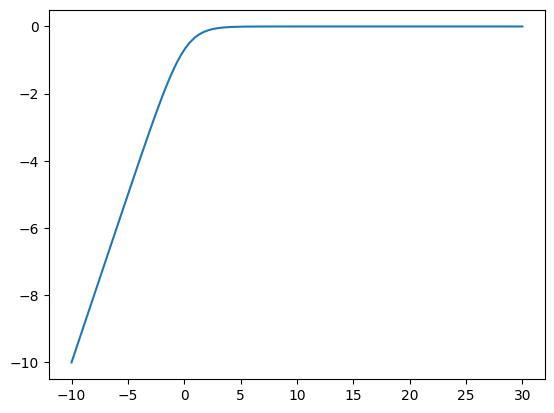

In [26]:
from torch.nn import functional as F
import torch
ref_nll_loss = torch.tensor(11)

nll_loss = torch.tensor(20)

x = torch.linspace(-10, 30, 100) # nll_loss - ref_nll_loss
y = F.softplus(x+ -1 * torch.log(torch.tensor(0.9)))
y = F.logsigmoid(x)

from matplotlib import pyplot as plt
plt.plot(x, y)

In [44]:
import numpy as np
np.exp(5)
np.log(1.1)

0.09531017980432493

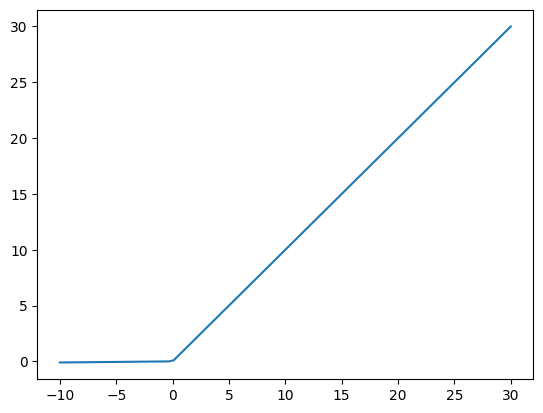

In [48]:
y = F.leaky_relu(x + 0.)
plt.plot(x, y)

In [34]:
torch.log(0.9)

TypeError: log(): argument 'input' (position 1) must be Tensor, not float